<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/fairness_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!pip install imbalanced-learn xgboost scikit-learn pandas matplotlib seaborn --quiet


In [2]:
!pip install lightgbm


In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
import shap
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression


In [4]:
# Load initial data frame
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/physionet/adr_features_with_subclass_labels.csv'
df = pd.read_csv(file_path)
print("Loaded data:", df.shape)
df.columns

Mounted at /content/drive
Loaded data: (17277, 438)


Index(['ADR', 'subject_id', 'hadm_id', 'icustay_id', 'window_start',
       'window_end', 'gender', 'age', 'ethnicity', 'admission_type',
       ...
       'Drain Out #1 Jackson Pratt_y', 'Chest Tubes CTICU CT 1_y',
       'Chest Tubes Other_y', 'Ultrafiltrate Ultrafiltrate_y',
       'Urine Out Suprapubic_y', 'Chest Tubes CTICU CT 2_y', 'Protonix gtt_y',
       'Urine ._y', 'cerebral drain right_y', 'NA Acetate/H2O_y'],
      dtype='object', length=438)

In [5]:
y = df['ADR']
# Feature matrix
X = df.drop(columns=[
'subject_id', 'hadm_id', 'window_start', 'window_end', 'ADR', 'ethnicity', 'icustay_id'
] + [col for col in df.columns if col.startswith('ADR_ICD_')])
X.columns
X.isna().any(axis=1).sum()
# Identify categorical and numeric columns
print(X.columns)
categorical_cols = ['gender', 'admission_type']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave the numeric columns untouched
)

# Apply preprocessing
X = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X = pd.DataFrame(X, columns=feature_names)

Index(['gender', 'age', 'admission_type', 'has_drug_allergy_history',
       'ICD_9671', 'ICD_9604', 'ICD_9390', 'ICD_9672', 'ICD_3995', 'ICD_4275',
       ...
       'Drain Out #1 Jackson Pratt_y', 'Chest Tubes CTICU CT 1_y',
       'Chest Tubes Other_y', 'Ultrafiltrate Ultrafiltrate_y',
       'Urine Out Suprapubic_y', 'Chest Tubes CTICU CT 2_y', 'Protonix gtt_y',
       'Urine ._y', 'cerebral drain right_y', 'NA Acetate/H2O_y'],
      dtype='object', length=424)


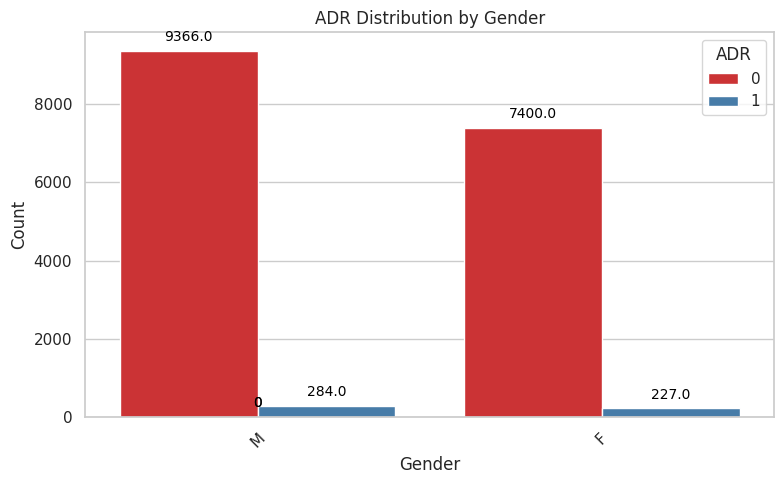

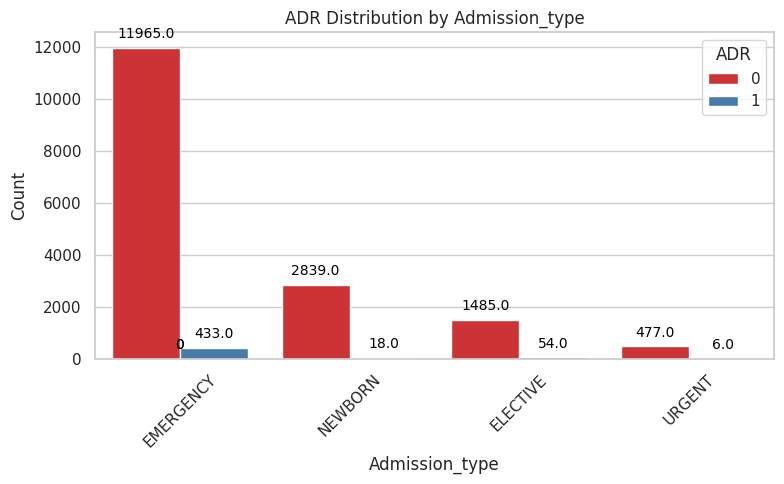

<Figure size 1200x600 with 0 Axes>

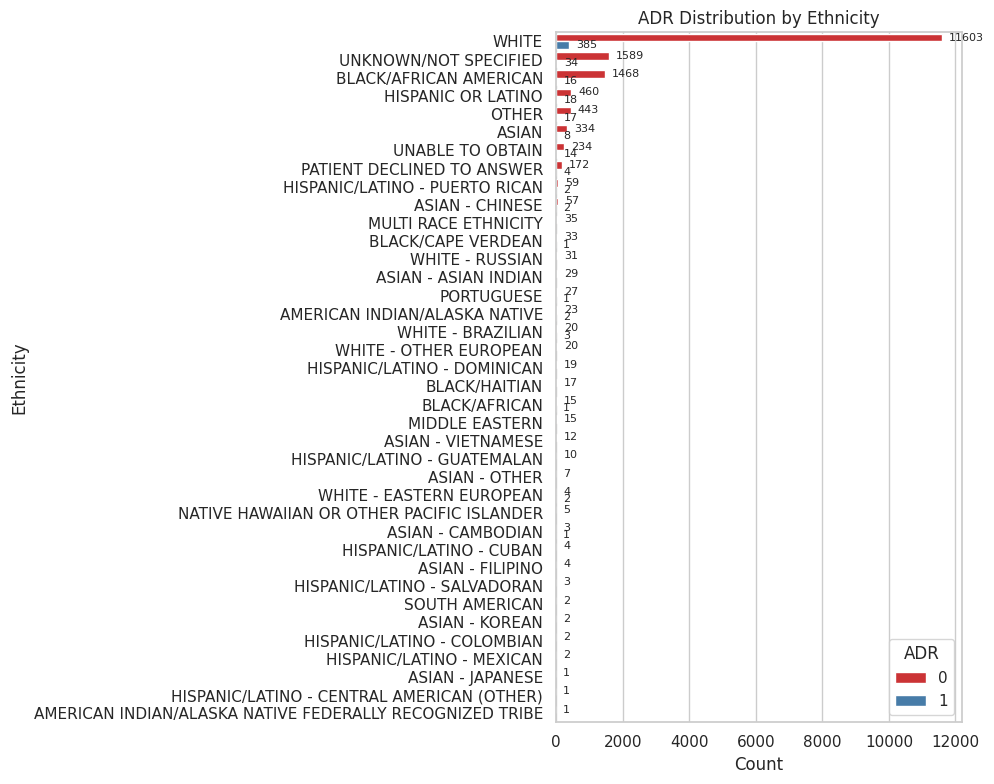

In [6]:
# Visualize the data across demographic dimensions
demographics = ['gender', 'admission_type']

# Set style
sns.set(style="whitegrid")

# Loop through each demographic variable
for col in demographics:
    plt.figure(figsize=(8, 5))

    # Create a count plot
    ax = sns.countplot(data=df, x=col, hue='ADR', palette='Set1')

    # Add value annotations
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Labeling
    plt.title(f'ADR Distribution by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='ADR', loc='upper right')
    plt.tight_layout()
    plt.show()
plt.figure(figsize=(12, 6))  # Wider figure for more space

# Create count plot
# ax = sns.countplot(data=df, x='ethnicity', hue='ADR', palette='Set1', order=df['ethnicity'].value_counts().index)

# # Rotate labels, wrap long text
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df, y='ethnicity', hue='ADR', palette='Set1', order=df['ethnicity'].value_counts().index)

# Add annotations
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=8, xytext=(5, 0), textcoords='offset points')

plt.title('ADR Distribution by Ethnicity')
plt.xlabel('Count')
plt.ylabel('Ethnicity')
plt.legend(title='ADR', loc='lower right')
plt.tight_layout()
plt.show()

In [7]:
def evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot = True):
  y_val_pred = (y_val_prob >= threshold).astype(int)
  print("\nClassification Report:")
  print(classification_report(y_val, y_val_pred))
  # Generate confusion matrix
  cm = confusion_matrix(y_val, y_val_pred)
  cm_df = pd.DataFrame(cm,
                     index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

  print("\nConfusion Matrix:")
  print(cm_df)

  roc_auc = roc_auc_score(y_val, y_val_prob)
  print("ROC AUC:", roc_auc)

  precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
  pr_auc = auc(recall, precision)
  if show_auc_plot:
    print("PR AUC:", pr_auc)

    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

  print("\nPredicted probabilities for true ADR 1:")
  df_val = pd.DataFrame({'true': y_val, 'prob': y_val_prob})
  print(df_val[df_val['true'] == 1])


  # Filter predictions for true class 0
  non_adr_probs = y_val_prob[y_val == 0]
  summary = {
    "mean": np.mean(non_adr_probs),
    "std": np.std(non_adr_probs),
    "min": np.min(non_adr_probs),
    "max": np.max(non_adr_probs),
    "median": np.median(non_adr_probs),
    "quantile_25": np.quantile(non_adr_probs, 0.25),
    "quantile_75": np.quantile(non_adr_probs, 0.75),
  }

  # Print results
  print("\nNon-ADR Predicted Probability Summary:")
  for k, v in summary.items():
      print(f"{k}: {v:.4f}")

In [8]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def shap_explanation(model, X, top_n=20):
    """
    Generate SHAP visualizations: positive/negative bar chart and interaction plot.

    Parameters:
    - model: trained model (compatible with SHAP)
    - X: pandas DataFrame of input features
    - top_n: number of top features to show (default=20)
    """
    import shap
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print("Explaining model...")
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Extract raw SHAP values safely as NumPy array
    shap_vals = shap_values.values
    if isinstance(shap_vals, list):  # For some multiclass models
        shap_vals = shap_vals[0]

    shap_vals = np.array(shap_vals)  # Ensure it's a NumPy array
    feature_names = X.columns

    # Compute mean positive and negative contributions
    mean_positive = (shap_vals * (shap_vals > 0)).mean(axis=0)
    mean_negative = (shap_vals * (shap_vals < 0)).mean(axis=0)

    # Create DataFrame for bar plot
    shap_df = pd.DataFrame({
        "feature": feature_names,
        "mean_positive": mean_positive,
        "mean_negative": mean_negative
    }).sort_values(by=["mean_positive", "mean_negative"], ascending=[False, True]).head(top_n)

    # Plot positive vs. negative contribution
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(shap_df["feature"], shap_df["mean_positive"], color="red", label="Positive impact")
    ax.barh(shap_df["feature"], shap_df["mean_negative"], color="blue", label="Negative impact")
    ax.set_xlabel("Mean SHAP value")
    ax.set_title("Mean Positive vs. Negative SHAP Values by Feature")
    ax.legend()
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Most important feature on top
    plt.show()

    # Feature interaction plot
    print("Showing SHAP interaction plot...")
    # Find column index directly to avoid name matching issues
    top_feature = shap_df.iloc[0]["feature"]
    feature_index = list(X.columns).index(top_feature)
    shap.dependence_plot(top_feature, shap_values.values, X, interaction_index="auto")



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

def plot_confidence_histogram(logits, true_labels, class_names=None, title="Confidence Histogram"):
    """
    Plots a histogram of predicted confidences, distinguishing correct and incorrect predictions.

    Args:
        logits (np.ndarray): Array of shape (n_samples, n_classes) with raw model outputs.
        true_labels (np.ndarray): Array of shape (n_samples,) with true class indices.
        class_names (list, optional): List of class names corresponding to class indices.
        title (str, optional): Title of the plot.
    """
    # Convert logits to probabilities
    probs = softmax(logits, axis=1)
    pred_labels = np.argmax(probs, axis=1)
    confidences = np.max(probs, axis=1)
    correct = pred_labels == true_labels

    # Create plot
    plt.figure(figsize=(8, 5))
    sns.histplot(x=confidences, hue=correct, bins=20, palette={True: "green", False: "red"}, kde=False)

    plt.xlabel("Predicted Confidence")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.legend(title="Correct", labels=["Incorrect", "Correct"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_prec_recall(all_precisions, all_avg_precisions, recall_points):
    mean_precision = np.mean(all_precisions, axis=0)
    std_precision = np.std(all_precisions, axis=0)
    mean_avg_precision = np.mean(all_avg_precisions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_points, mean_precision, label=f'Mean PR (AP = {mean_avg_precision:.2f})')
    plt.fill_between(recall_points,
                     mean_precision - std_precision,
                     mean_precision + std_precision,
                     alpha=0.2,
                     label='±1 std dev')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average Precision-Recall Curve (5-Fold CV)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Collects ADR subgroup scores from each fold
def collect_adr_probs_by_subgroup(X_val, y_val, y_val_prob, features_df, adr_icd_cols, adr_subgroup_scores):
    val_results = X_val.copy()
    val_results['y_val_prob'] = y_val_prob
    val_results['true_label'] = y_val.values
    val_results = val_results.rename(columns={'remainder__icustay_id': 'icustay_id'})
    val_results = val_results.merge(df[['icustay_id'] + adr_icd_cols], on='icustay_id', how='left')

    for col in adr_icd_cols:
        if col in val_results:
            avg_prob = val_results.loc[val_results[col] == 1, 'y_val_prob'].mean()
            if not np.isnan(avg_prob):
                adr_subgroup_scores[col].append(avg_prob)

def plot_avg_adr_probs(adr_subgroup_scores):
    import matplotlib.pyplot as plt
    import numpy as np

    # Compute means, stds, and counts
    mean_probs = {k: np.mean(v) for k, v in adr_subgroup_scores.items() if v}
    std_devs = {k: np.std(v) for k, v in adr_subgroup_scores.items() if v}
    counts = {k: len(v) for k, v in adr_subgroup_scores.items() if v}

    # Sort by mean predicted prob
    sorted_keys = sorted(mean_probs, key=mean_probs.get, reverse=True)
    means = [mean_probs[k] for k in sorted_keys]
    stds = [std_devs[k] for k in sorted_keys]
    n_samples = [counts[k] for k in sorted_keys]

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.barh(sorted_keys, means, xerr=stds, color='skyblue', edgecolor='black')
    ax1.set_xlabel("Average Predicted ADR Probability")
    ax1.set_title("Model Confidence by ADR Type (+ Std Dev)")
    ax1.invert_yaxis()

    # Add a second axis to show sample counts
    ax2 = ax1.twiny()
    ax2.plot(n_samples, sorted_keys, 'r.', label="# of Samples")
    ax2.set_xlabel("Number of Patients with ADR Type")

    plt.tight_layout()
    plt.show()
def plot_mean_roc_curve(all_fpr, all_tpr, fpr_points):
    """
    Plots the mean ROC curve across multiple folds.

    Parameters:
    - all_fpr: List of interpolated FPR arrays for each fold
    - all_tpr: List of interpolated TPR arrays for each fold
    - fpr_points: Uniformly spaced FPR points used for interpolation
    """
    mean_tpr = np.mean(all_tpr, axis=0)
    mean_tpr[-1] = 1.0  # Ensure curve ends at 1
    mean_auc = auc(fpr_points, mean_tpr)
    std_tpr = np.std(all_tpr, axis=0)

    plt.figure()
    plt.plot(fpr_points, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)
    plt.fill_between(fpr_points, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve Across Folds')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Strategy #1: SMOTE with XGBoost, with scaled weighting for class prediction

In [12]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_best_f1_threshold(y_true, y_scores):
    """
    Finds the threshold that maximizes F1-score from predicted probabilities.

    Parameters:
    - y_true: Ground truth binary labels (array-like)
    - y_scores: Predicted probabilities for the positive class (array-like)

    Returns:
    - best_threshold: Threshold that gives the highest F1 score
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else 0.5  # thresholds is len - 1

    print(f"Best F1 Threshold: {best_threshold:.4f}")
    print(f"Precision: {precisions[best_index]:.4f}, Recall: {recalls[best_index]:.4f}, F1: {f1_scores[best_index]:.4f}")

    return best_threshold


In [13]:

def compute_predictions(model, X_train, y_train, X_val):
    model.fit(X_train, y_train)
    return model.predict_proba(X_val)[:, 1]

def interpolate_metrics(y_true, y_scores, recall_points):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    interp_precision = np.interp(recall_points, recall[::-1], precision[::-1])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    interp_tpr = np.interp(recall_points, fpr, tpr)
    interp_tpr[0] = 0.0

    return interp_precision, avg_precision, interp_tpr

def evaluate_threshold_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    return precision, recall, f1, roc_auc

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration_curve(y_true, y_prob, n_bins=10, title="Calibration Plot"):
    """
    Plots a calibration curve to show how well predicted probabilities match actual outcomes.

    Args:
        y_true (np.ndarray): True binary labels (0 or 1).
        y_prob (np.ndarray): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to group predictions.
        title (str): Title for the plot.
    """
    # Ensure y_prob is 1D (for binary classification)
    if y_prob.ndim > 1 and y_prob.shape[1] == 2:
        y_prob = y_prob[:, 1]

    # Get calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def evaluate_fairness_by_gender(y_true, y_pred, genders):
    unique_genders = genders.unique()
    print("\nFairness Evaluation by Gender:")
    metrics_by_gender = {}

    for g in unique_genders:
        mask = genders == g
        y_g = y_true[mask]
        y_p = y_pred[mask]

        # Confusion matrix
        cm = confusion_matrix(y_g, y_p, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        print(f"\nGender: {g}")
        print(pd.DataFrame(cm,
                           index=["Actual Negative", "Actual Positive"],
                           columns=["Predicted Negative", "Predicted Positive"]))

        # Fairness metrics
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * precision * tpr / (precision + tpr) if (precision + tpr) > 0 else 0
        pos_rate = (tp + fp) / len(y_g)  # Demographic parity

        print(f"TPR (Recall):            {tpr:.3f}")
        print(f"FPR:                     {fpr:.3f}")
        print(f"Precision:               {precision:.3f}")
        print(f"F1 Score:                {f1:.3f}")
        print(f"Demographic Parity:      {pos_rate:.3f}")

        metrics_by_gender[g] = {
            "TPR": tpr,
            "FPR": fpr,
            "Precision": precision,
            "F1": f1,
            "Demographic Parity": pos_rate
        }

    # Compute disparities
    if len(unique_genders) == 2:
        genders_list = list(unique_genders)
        print("\nDisparity Between Genders:")
        for metric in metrics_by_gender[genders_list[0]]:
            val1 = metrics_by_gender[genders_list[0]][metric]
            val2 = metrics_by_gender[genders_list[1]][metric]
            disparity = abs(val1 - val2)
            print(f"{metric} disparity: {disparity:.3f}")



In [18]:
print(X.columns)

Index(['cat__gender_F', 'cat__gender_M', 'cat__admission_type_ELECTIVE',
       'cat__admission_type_EMERGENCY', 'cat__admission_type_NEWBORN',
       'cat__admission_type_URGENT', 'remainder__age',
       'remainder__has_drug_allergy_history', 'remainder__ICD_9671',
       'remainder__ICD_9604',
       ...
       'remainder__Drain Out #1 Jackson Pratt_y',
       'remainder__Chest Tubes CTICU CT 1_y', 'remainder__Chest Tubes Other_y',
       'remainder__Ultrafiltrate Ultrafiltrate_y',
       'remainder__Urine Out Suprapubic_y',
       'remainder__Chest Tubes CTICU CT 2_y', 'remainder__Protonix gtt_y',
       'remainder__Urine ._y', 'remainder__cerebral drain right_y',
       'remainder__NA Acetate/H2O_y'],
      dtype='object', length=428)


Best F1 Threshold: 0.1888
Precision: 0.2784, Recall: 0.2647, F1: 0.2714
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3354
           1       0.28      0.26      0.27       102

    accuracy                           0.96      3456
   macro avg       0.63      0.62      0.62      3456
weighted avg       0.96      0.96      0.96      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3284                  70
Actual Positive                  75                  27
ROC AUC: 0.8569983747822325

Predicted probabilities for true ADR 1:
       true      prob
417       1  0.017026
562       1  0.239918
780       1  0.026184
892       1  0.154950
1035      1  0.177497
...     ...       ...
16214     1  0.023675
16235     1  0.011594
16248     1  0.084302
16897     1  0.021918
17216     1  0.039675

[102 rows x 2 columns]

Non-ADR Predicted Prob

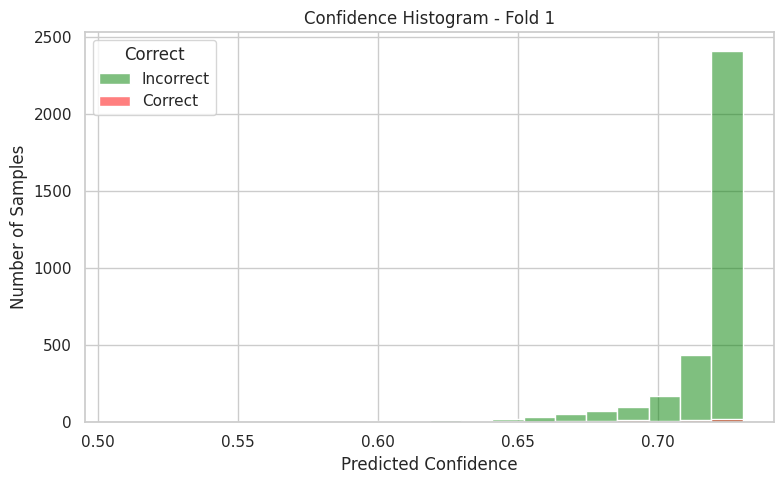

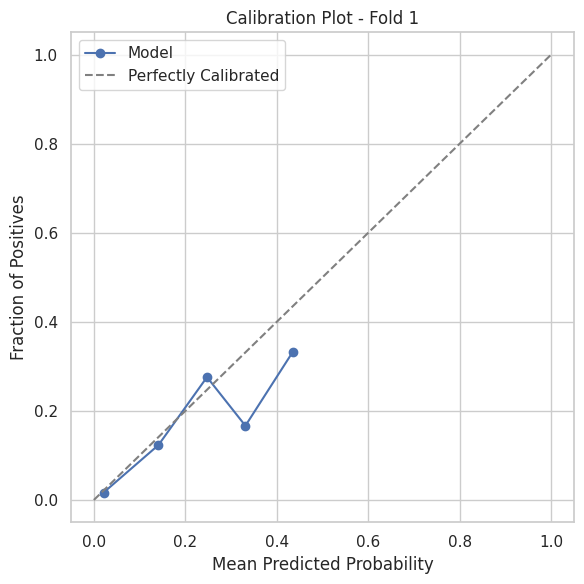


Fairness Evaluation by Gender:

Gender: M
                 Predicted Negative  Predicted Positive
Actual Negative                1825                  37
Actual Positive                  40                  16
TPR (Recall):            0.286
FPR:                     0.020
Precision:               0.302
F1 Score:                0.294
Demographic Parity:      0.028

Gender: F
                 Predicted Negative  Predicted Positive
Actual Negative                1459                  33
Actual Positive                  35                  11
TPR (Recall):            0.239
FPR:                     0.022
Precision:               0.250
F1 Score:                0.244
Demographic Parity:      0.029

Disparity Between Genders:
TPR disparity: 0.047
FPR disparity: 0.002
Precision disparity: 0.052
F1 disparity: 0.049
Demographic Parity disparity: 0.001
Best F1 Threshold: 0.1504
Precision: 0.2092, Recall: 0.3107, F1: 0.2500
batch # 2

Classification Report:
              precision    recall  f1-sco

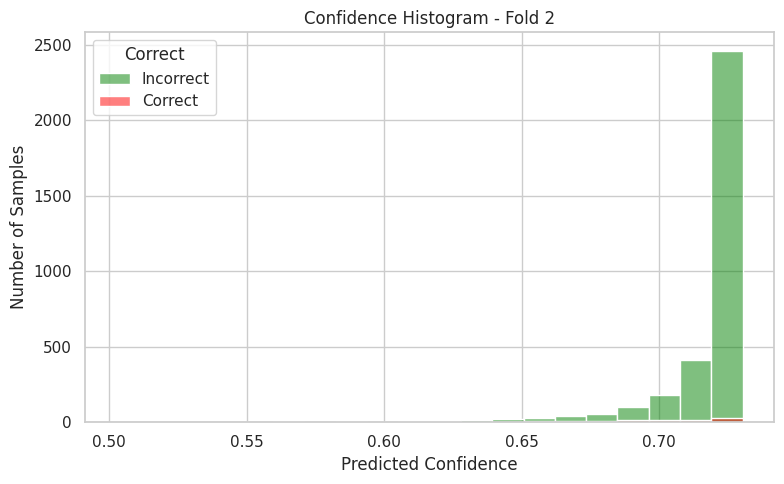

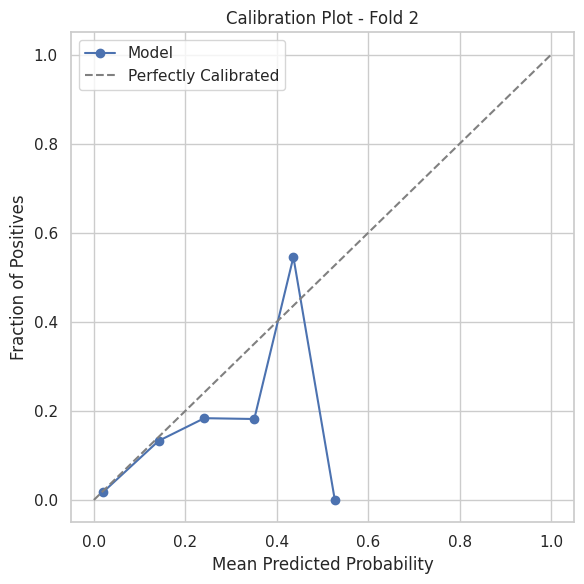


Fairness Evaluation by Gender:

Gender: M
                 Predicted Negative  Predicted Positive
Actual Negative                1848                  60
Actual Positive                  43                  19
TPR (Recall):            0.306
FPR:                     0.031
Precision:               0.241
F1 Score:                0.270
Demographic Parity:      0.040

Gender: F
                 Predicted Negative  Predicted Positive
Actual Negative                1384                  61
Actual Positive                  28                  13
TPR (Recall):            0.317
FPR:                     0.042
Precision:               0.176
F1 Score:                0.226
Demographic Parity:      0.050

Disparity Between Genders:
TPR disparity: 0.011
FPR disparity: 0.011
Precision disparity: 0.065
F1 disparity: 0.043
Demographic Parity disparity: 0.010
Best F1 Threshold: 0.1083
Precision: 0.1715, Recall: 0.4020, F1: 0.2405
batch # 3

Classification Report:
              precision    recall  f1-sco

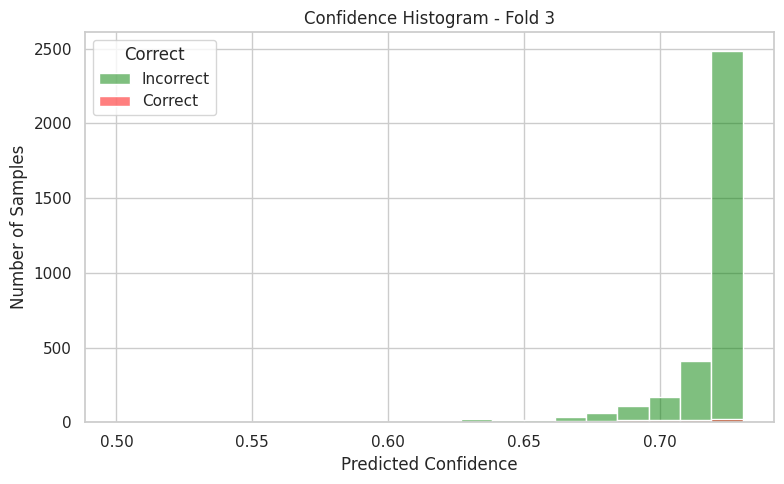

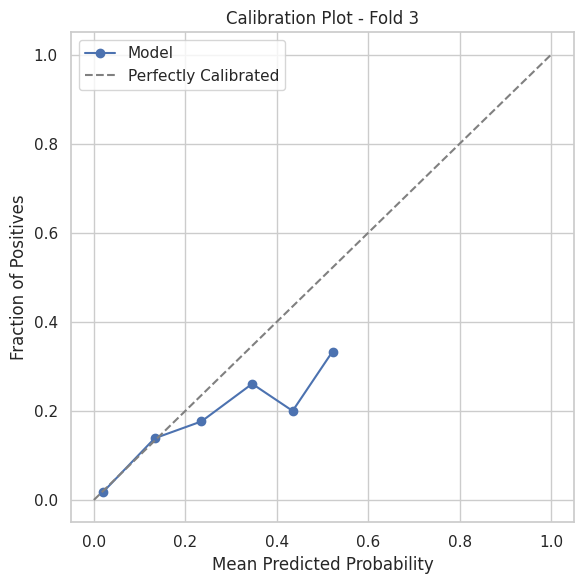


Fairness Evaluation by Gender:

Gender: M
                 Predicted Negative  Predicted Positive
Actual Negative                1752                 106
Actual Positive                  31                  20
TPR (Recall):            0.392
FPR:                     0.057
Precision:               0.159
F1 Score:                0.226
Demographic Parity:      0.066

Gender: F
                 Predicted Negative  Predicted Positive
Actual Negative                1403                  92
Actual Positive                  30                  21
TPR (Recall):            0.412
FPR:                     0.062
Precision:               0.186
F1 Score:                0.256
Demographic Parity:      0.073

Disparity Between Genders:
TPR disparity: 0.020
FPR disparity: 0.004
Precision disparity: 0.027
F1 disparity: 0.030
Demographic Parity disparity: 0.007
Best F1 Threshold: 0.1034
Precision: 0.1862, Recall: 0.5294, F1: 0.2755
batch # 4

Classification Report:
              precision    recall  f1-sco

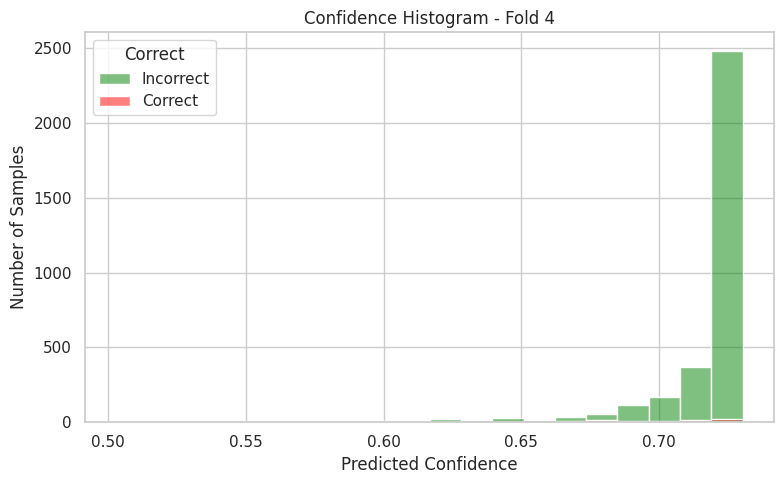

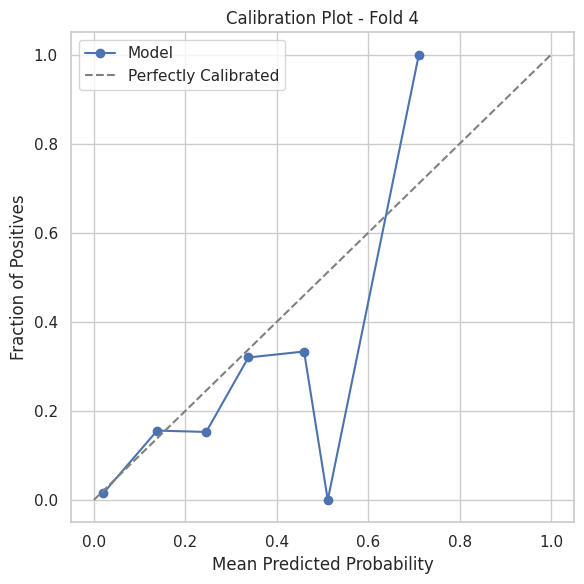


Fairness Evaluation by Gender:

Gender: F
                 Predicted Negative  Predicted Positive
Actual Negative                1397                 123
Actual Positive                  23                  20
TPR (Recall):            0.465
FPR:                     0.081
Precision:               0.140
F1 Score:                0.215
Demographic Parity:      0.091

Gender: M
                 Predicted Negative  Predicted Positive
Actual Negative                1720                 113
Actual Positive                  25                  34
TPR (Recall):            0.576
FPR:                     0.062
Precision:               0.231
F1 Score:                0.330
Demographic Parity:      0.078

Disparity Between Genders:
TPR disparity: 0.111
FPR disparity: 0.019
Precision disparity: 0.091
F1 disparity: 0.115
Demographic Parity disparity: 0.014
Best F1 Threshold: 0.1686
Precision: 0.2214, Recall: 0.3039, F1: 0.2562
batch # 5

Classification Report:
              precision    recall  f1-sco

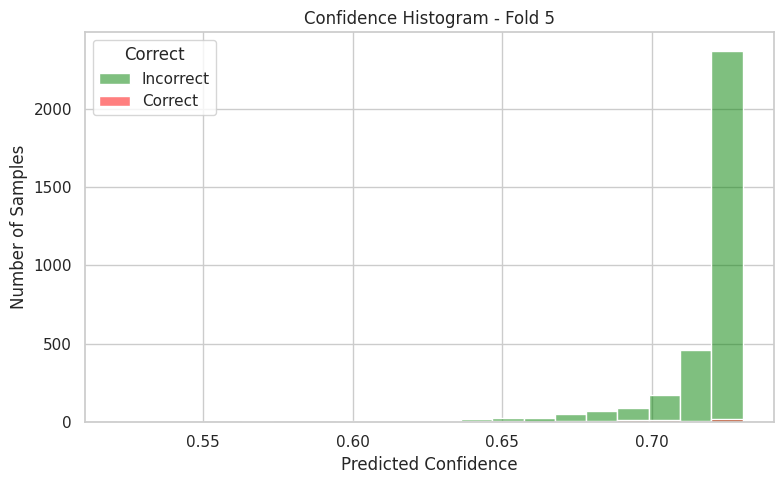

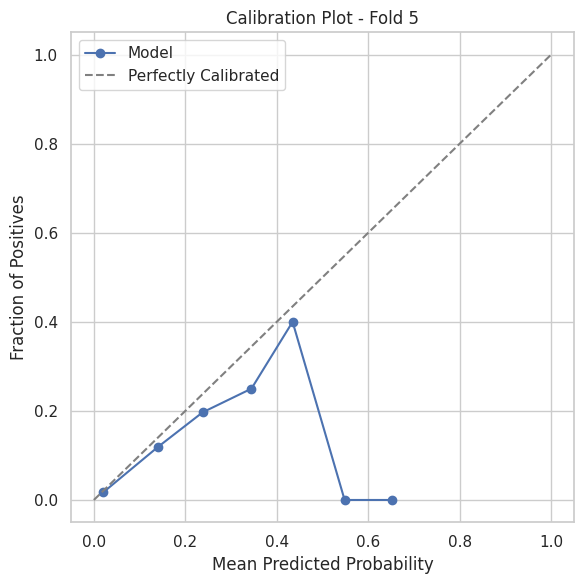


Fairness Evaluation by Gender:

Gender: F
                 Predicted Negative  Predicted Positive
Actual Negative                1408                  40
Actual Positive                  37                   9
TPR (Recall):            0.196
FPR:                     0.028
Precision:               0.184
F1 Score:                0.189
Demographic Parity:      0.033

Gender: M
                 Predicted Negative  Predicted Positive
Actual Negative                1836                  69
Actual Positive                  34                  22
TPR (Recall):            0.393
FPR:                     0.036
Precision:               0.242
F1 Score:                0.299
Demographic Parity:      0.046

Disparity Between Genders:
TPR disparity: 0.197
FPR disparity: 0.009
Precision disparity: 0.058
F1 disparity: 0.110
Demographic Parity disparity: 0.014


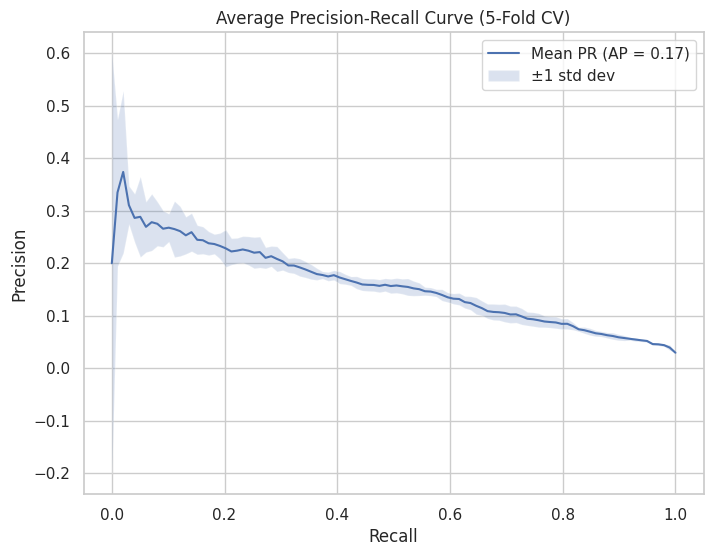

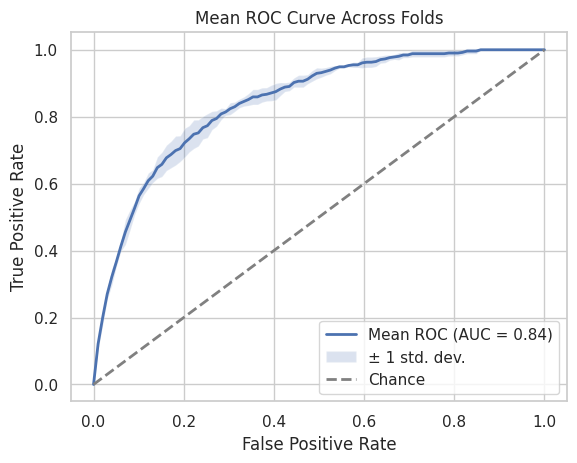


Overall Performance Across 5 Folds:
Average Precision: 0.2133 ± 0.0369
Average Recall:    0.3621 ± 0.0950
Average F1-score:  0.2587 ± 0.0131
Average ROC AUC:   0.8425 ± 0.0110


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [22]:
def smotomek_xgboost(X, y):
  model = None
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  precision_list = []
  recall_list = []
  f1_list = []
  roc_auc_list = []
  all_precisions = []
  all_recalls = []
  all_avg_precisions = []
  all_tprs = []

  # Define a uniform set of recall points for interpolation
  recall_points = np.linspace(0, 1, 100)

  batch_no = 0
  for train_index, val_index in skf.split(X, y):
      batch_no += 1
      X_train, X_val = X.iloc[train_index], X.iloc[val_index]
      y_train, y_val = y.iloc[train_index], y.iloc[val_index]

      smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
      X_resampled, y_resampled = smt.fit_resample(X_train, y_train)


      model = xgb.XGBClassifier(
      eval_metric='logloss',
      scale_pos_weight=1,
      learning_rate=0.05,
      max_depth=3,
      n_estimators=300,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42
      )

      y_val_prob = compute_predictions(model, X_resampled, y_resampled, X_val)
      threshold = find_best_f1_threshold(y_val, y_val_prob)
      print(f"batch # {batch_no}")
      evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)
      if y_val_prob.ndim == 1:
    # Binary classification: convert to 2D pseudo-prob array [1 - p, p]
        probs = np.vstack([1 - y_val_prob, y_val_prob]).T
      else:
        probs = y_val_prob
      plot_confidence_histogram(logits=probs, true_labels=y_val.values, title=f"Confidence Histogram - Fold {batch_no}")
      plot_calibration_curve(y_val, y_val_prob, title=f"Calibration Plot - Fold {batch_no}")

      # Collect metrics for avg prec recall curv
      interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
      all_precisions.append(interp_precision)
      all_avg_precisions.append(avg_precision)
      all_tprs.append(interp_tpr)

      precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)
      roc_auc_list.append(auc_score)
      #shap_explanation(model, X_resampled)

      # 🔍 Fairness Evaluation (per gender)
      y_val_pred = (y_val_prob >= threshold).astype(int)
      gender_series = X_val[['cat__gender_F', 'cat__gender_M']].idxmax(axis=1).str[-1]
      evaluate_fairness_by_gender(y_val, y_val_pred, gender_series)  # <== Adjust if your gender column has a different name

      #shap_explanation(model, X_resampled, X_val.drop(columns=['remainder__icustay_id']))
  plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
  plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)



  print("\nOverall Performance Across 5 Folds:")
  print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
  print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
  print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
  print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
  return model

smotomek_xgboost(X, y)
